# GRAD-E1326: Python Programming for Data Scientists
## Ph.D. Hannah Béchara
### Ji Yoon Han & Mariana G. Carrillo 

**Initial Project report: Tweet Sentiment Analysis**


In [1]:
#Importing libraries for sentiment analysis 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk #Natural Language Processing Package 
import os #functions for interacting with the operating system
import spacy #Models for NLP
import torch #also for NLP
from tqdm.notebook import tqdm 
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import transformers #contains pretrained models to perform tasks on texts
from transformers import BertForSequenceClassification
from wordcloud import WordCloud #For nice wordclouds
import tensorflow as tf #Package to develop train models 
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import time #for handling dates and times
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import TweetTokenizer


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading data

In [2]:
#Loading and cleaning data
train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')

In [3]:
#Train data 
#preview
train_data.head(5)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
#descriptive statistics
train_data.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [5]:
#Test data
#preview
test_data.head(5)




,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Data pre-processing

In [6]:
#descriptive statistics
test_data.describe()

,UserName,ScreenName
count,3798.000000,3798.000000
mean,1899.500000,46851.500000
std,1096.532489,1096.532489
min,1.000000,44953.000000
25%,950.250000,45902.250000
50%,1899.500000,46851.500000
75%,2848.750000,47800.750000
max,3798.000000,48750.000000


### Exploratory Data analysis

Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Test data)')

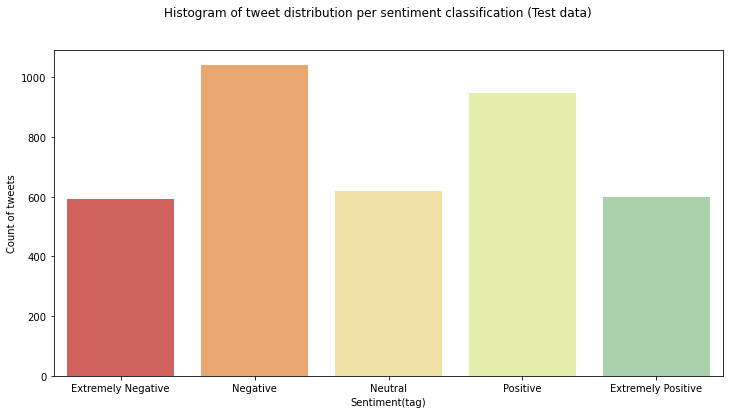

In [7]:


#Create histogram --> Distribution TEST DATA
#Can we also make this a function?
plt.figure(figsize=(12,6)) #specifying the size of the figure
sns.set_palette("Spectral") #color palette
sns.countplot(x='Sentiment', data=test_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment(tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Test data)')


Text(0.5, 0.98, 'Histogram of tweet distribution per sentiment classification (Train data)')

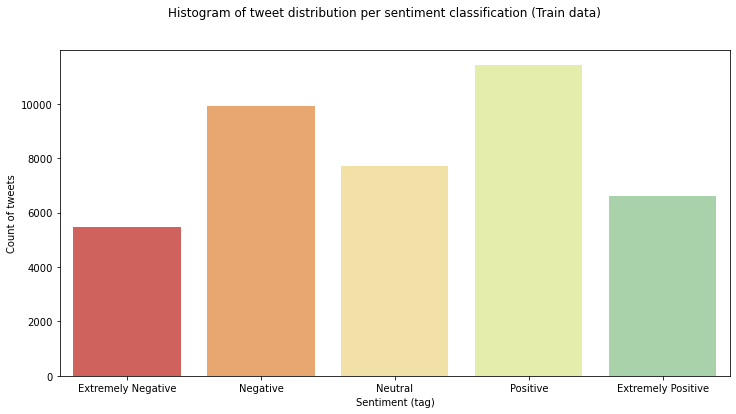

In [8]:
#Create histogram --> Distribution TRAIN DATA
plt.figure(figsize=(12,6))
sns.set_palette("Spectral")
sns.countplot(x='Sentiment', data=train_data, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.xlabel('Sentiment (tag)')
plt.ylabel('Count of tweets')
plt.suptitle('Histogram of tweet distribution per sentiment classification (Train data)')

Text(0, 0.5, 'Tweet Count')

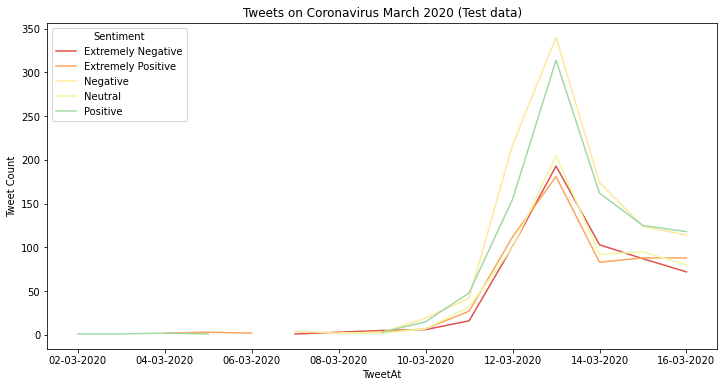

In [9]:
#Distribution of tweet counts 
test_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus March 2020 (Test data)')
plt.ylabel('Tweet Count')

Text(0, 0.5, 'Tweet Count')

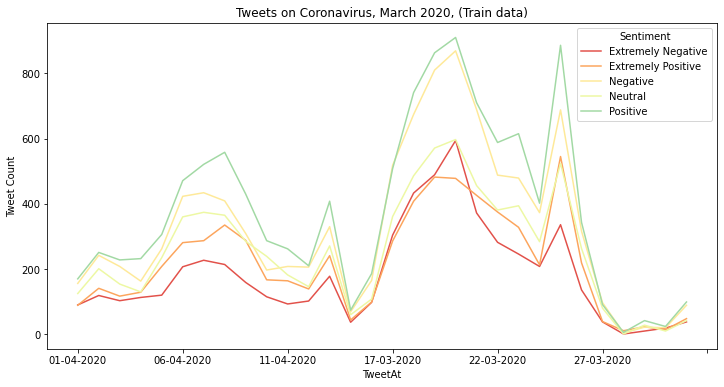

In [10]:
#Distribution of tweet counts 
train_data.groupby(['TweetAt', 'Sentiment'])['OriginalTweet'].count().unstack().plot(kind='line', figsize=(12, 6))
plt.title('Tweets on Coronavirus, March 2020, (Train data)')
plt.ylabel('Tweet Count')

### Data cleaning

In [11]:
stop_words = stopwords.words('english') #defining var to remove stopwords in the process_tweet function 

#create a function that allows to process the tweets by:

def process_tweet(tweet):
    
    # removing urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # removing html tags
    tweet = re.sub(r'<.*?>', ' ', tweet)
    
    # removing digits
    tweet = re.sub(r'\d+', ' ', tweet)
    
    # removing hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)
    
    # removing mentions
    tweet = re.sub(r'@\w+', ' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet




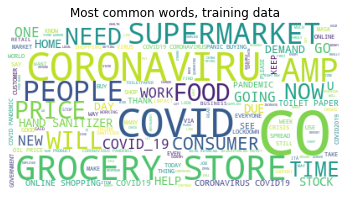

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Attempt to create wordcloud
def wordcloud1(training_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud1 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in train_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud1)
    plt.axis("off")
    plt.title("Most common words, training data")
    figsize=(12, 6)

wordcloud1(train_data)  

In [ ]:
#Attempt to create wordcloud - test data
def wordcloud2(test_data):
    stopwords = set(STOPWORDS)
    stopwords.add("https")
    stopwords.add("00A0")
    stopwords.add("00BD")
    stopwords.add("00B8")
    stopwords.add("ed")
    wordcloud2 = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in test_data['OriginalTweet'].str.upper()]))
    plt.imshow(wordcloud2)
    plt.axis("off")
    plt.title("Most common words, training data")
    figsize=(12, 6)

wordcloud2(test_data)  

### Tokenization

In [12]:
#Using tweet tokenizer
#Evaluate different tokenizers



#How can we write a function to tokenize all tweets? 

def tweet_Tokenizer()


SyntaxError: invalid syntax (<ipython-input-12-41120e268d11>, line 8)

* 

### References 
* Matplotlib.org. 2020. Pyplot Tutorial — Matplotlib 3.3.2 Documentation. [online] Available at: <https://matplotlib.org/tutorials/introductory/pyplot.html> [Accessed 20 October 2020].
* Kaggle.com. 2020. Sentiment Prediction. [online] Available at: <https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc> [Accessed 18 October 2020].
* 